In [1]:
import os.path as osp

import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import exp_utils

In [2]:
# ref: https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [3]:
rl_policies_results_dir_name = '2022-05-01 12:15:52.217455'
rl_policies_results_file = osp.join(exp_utils.EXP_RESULTS_DIR, rl_policies_results_dir_name, "compiled_results.csv")
rl_pw_df = pandas.read_csv(rl_policies_results_file)

baposgmcp_results_dir_name = '2022-05-01 08:38:52.595444'
baposgmcp_results_file = osp.join(exp_utils.EXP_RESULTS_DIR, baposgmcp_results_dir_name, "compiled_results.csv")
baposgmcp_pw_df = pandas.read_csv(baposgmcp_results_file)

columns_to_drop = [
    'Unnamed: 0', 'env_name', 'episode_step_limit', 'time_limit', 
    'search_time_mean', 'search_time_std', 'update_time_mean', 'update_time_std',
    'reinvigoration_time_mean', 'reinvigoration_time_std', 'policy_calls_mean', 
    'policy_calls_std', 'inference_time_mean', 'inference_time_std',
    'episode_dones', 'num_outcome_LOSS', 'num_outcome_DRAW', 'num_outcome_WIN', 
    'num_outcome_NA'
]
rl_pw_df = rl_pw_df.drop(columns_to_drop, axis=1)
baposgmcp_pw_df = baposgmcp_pw_df.drop(columns_to_drop, axis=1)

In [4]:
rl_pw_df.columns

Index(['exp_id', 'agent_id', 'seed', 'num_episodes', 'policy_name',
       'policy_id', 'episode_returns_mean', 'episode_returns_std',
       'episode_returns_max', 'episode_returns_min',
       'episode_discounted_returns_mean', 'episode_discounted_returns_std',
       'episode_discounted_returns_max', 'episode_discounted_returns_min',
       'episode_steps_mean', 'episode_steps_std', 'episode_times_mean',
       'episode_times_std'],
      dtype='object')

In [5]:
def get_k(row):
    pi_name = row["policy_name"]
    if "Random" in pi_name:
        return str(-1)
    if "BAPOSGMCP" in pi_name:
        return "BA"
    try:
        return pi_name.split("_")[-1]
    except Exception:
        raise Exception("Policy name error")

rl_pw_df["K"] = rl_pw_df.apply(get_k, axis=1)
baposgmcp_pw_df["K"] = baposgmcp_pw_df.apply(get_k, axis=1)

In [8]:
def get_rl_pw_returns():
    agent_ids = rl_pw_df["agent_id"].unique()
    agent_ids.sort()
    k_levels = rl_pw_df["K"].unique()
    k_levels.sort()

    pw_returns = np.zeros((len(k_levels), len(k_levels)))
    row_agent = agent_ids[0]
    col_agent = agent_ids[1]

    for c, col_k in enumerate(k_levels):
        col_agent_exp_ids = rl_pw_df[(rl_pw_df["agent_id"] == col_agent) & (rl_pw_df["K"] == col_k)]["exp_id"]
        for r, row_k in enumerate(reversed(k_levels)):
            pw_returns[r][c] = rl_pw_df[
                (rl_pw_df["agent_id"] == row_agent) 
                & (rl_pw_df["K"] == row_k)
                & (rl_pw_df["exp_id"].isin(col_agent_exp_ids))
            ]["episode_discounted_returns_mean"]
    
    return k_levels, pw_returns

k_levels=array(['-1', '0', '1', 'BR'], dtype=object)
pw_returns:
[[ 9.69839021 10.18253834 10.49023511 10.32250416]
 [11.03430756 11.58790835 11.71346816 11.58697011]
 [11.01533759 11.54450154 11.42631406 11.30828198]
 [-0.55596396 -0.50815795 -0.56581179 -0.3878432 ]]


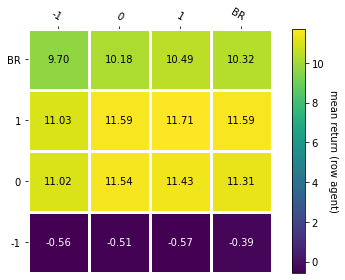

In [9]:
k_levels, pw_returns = get_rl_pw_returns()
print(f"{k_levels=}")
print(f"pw_returns:\n{pw_returns}")

fig, ax = plt.subplots()
im, cbar = heatmap(
    data=pw_returns, 
    row_labels=reversed(k_levels),
    col_labels=k_levels,
    ax=ax,
    cmap="viridis",
    cbarlabel="mean return (row agent)"
)
texts = annotate_heatmap(
    im, 
    valfmt="{x:.2f}",
    textcolors=("white", "black")
)

fig.tight_layout()
fig.savefig(osp.join(exp_utils.EXP_BASE_DIR, "figures", "pw_rl_performance.png"))
plt.show()

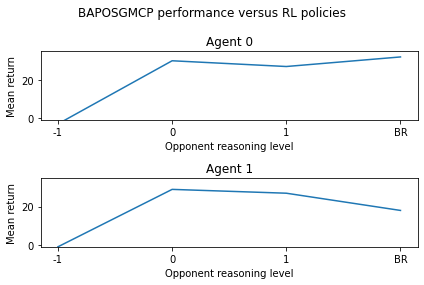

In [71]:
agent_ids = baposgmcp_pw_df["agent_id"].unique()
agent_ids.sort()
k_levels = baposgmcp_pw_df["K"].unique()
k_levels.sort()

fig, axs = plt.subplots(2)
for i, agent_id in enumerate(agent_ids):
    opp_id = (agent_id + 1) % 2
    ax = axs[i]
    agent_df = baposgmcp_pw_df[baposgmcp_pw_df["agent_id"] == agent_id]
    exp_ids = agent_df[agent_df["K"] == "BA"]["exp_id"]
    x = []
    y = []
    for k in k_levels:
        if k == "BA":
            continue
        opp_df = baposgmcp_pw_df[
            (baposgmcp_pw_df["agent_id"] == opp_id) 
            & (baposgmcp_pw_df["exp_id"].isin(exp_ids))
            & (baposgmcp_pw_df["K"] == k)
        ]
        x.append(k)
        y.append(opp_df["episode_returns_mean"])
    
    ax.plot(x, y)
    ax.set_xticks(x)
    ax.set_xlabel("Opponent reasoning level")
    ax.set_ylabel("Mean return")
    ax.set_title(f"Agent {agent_id}")
    ax.set_ylim(-1, 35)
    
fig.suptitle("BAPOSGMCP performance versus RL policies")
fig.tight_layout()
fig.savefig(osp.join(exp_utils.EXP_BASE_DIR, "figures", "pw_baposgmcp_performance.png"))
plt.show()

rl_k_levels=['-1', '0', '1', 'BR']
rl_pw_returns=array([[20., 29., 24.,  9.],
       [19., 27., 31., 27.],
       [28., 25., 34., 16.],
       [-3., -2., -3.,  1.]])
ba_k_levels=array(['-1', '0', '1', 'BA', 'BR'], dtype=object)


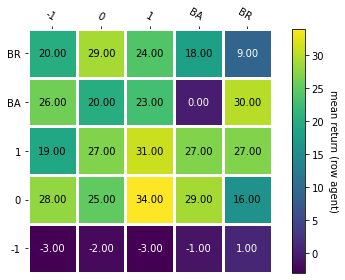

In [75]:
rl_k_levels, rl_pw_returns = get_rl_pw_returns()
rl_k_levels = rl_k_levels.tolist()
print(f"{rl_k_levels=}")
print(f"{rl_pw_returns=}")
row_rl_k_levels = list(reversed(rl_k_levels))

agent_ids = baposgmcp_pw_df["agent_id"].unique()
agent_ids.sort()
ba_k_levels = baposgmcp_pw_df["K"].unique()
ba_k_levels.sort()
print(f"{ba_k_levels=}")

all_pw_returns = np.zeros((len(ba_k_levels), len(ba_k_levels)))
row_agent = agent_ids[0]
col_agent = agent_ids[1]

for c, col_k in enumerate(ba_k_levels):
    for r, row_k in enumerate(reversed(ba_k_levels)):
        if row_k == "BA" and col_k == "BA":
            continue
        elif row_k != "BA" and col_k != "BA":
            # copy result from RL pairwise result
            row_k_idx = row_rl_k_levels.index(row_k)
            col_k_idx = rl_k_levels.index(col_k)
            all_pw_returns[r][c] = rl_pw_returns[row_k_idx][col_k_idx]
        else:
            # get result from BAPOSGMCP dataframe
            col_agent_exp_ids = baposgmcp_pw_df[
                (baposgmcp_pw_df["agent_id"] == col_agent) 
                & (baposgmcp_pw_df["K"] == col_k)
            ]["exp_id"]
        
            all_pw_returns[r][c] = baposgmcp_pw_df[
                (baposgmcp_pw_df["agent_id"] == row_agent) 
                & (baposgmcp_pw_df["K"] == row_k)
                & (baposgmcp_pw_df["exp_id"].isin(col_agent_exp_ids))
            ]["episode_returns_mean"]

        
fig, ax = plt.subplots()
im, cbar = heatmap(
    data=all_pw_returns, 
    row_labels=reversed(ba_k_levels),
    col_labels=ba_k_levels,
    ax=ax,
    cmap="viridis",
    cbarlabel="mean return (row agent)"
)
texts = annotate_heatmap(
    im, 
    valfmt="{x:.2f}",
    textcolors=("white", "black")
)

fig.tight_layout()
fig.savefig(osp.join(exp_utils.EXP_BASE_DIR, "figures", "all_pw_performance.png"))
plt.show()